---
# PySpark Machine Learning Models
---
* Use Spark to build ML models of your choice (classification – regression) in the attempt of solving your business problem. 
* Build at least 4 models, optimize them, test them, and include your results. You will not be graded on accuracy and it is more important that you are implementing your techniques correctly even if the model does not return the intended results. If your model does not provide sufficient accuracy levels, make sure to present your work while explaining possible reasons behind this shortfall. 

### **Column:**

* legId: An identifier for the flight.
* searchDate: The date (YYYY-MM-DD) on which this entry was taken from Expedia.
* flightDate: The date (YYYY-MM-DD) of the flight.
* startingAirport: Three-character IATA airport code for the initial location.
* destinationAirport: Three-character IATA airport code for the arrival location.
* fareBasisCode: The fare basis code.
* travelDuration: The travel duration in hours and minutes.
* elapsedDays: The number of elapsed days (usually 0).
* isBasicEconomy: Boolean for whether the ticket is for basic economy.
* isRefundable: Boolean for whether the ticket is refundable.
* isNonStop: Boolean for whether the flight is non-stop.
* baseFare: The price of the ticket (in USD).
* totalFare: The price of the ticket (in USD) including taxes and other fees.
* seatsRemaining: Integer for the number of seats remaining.
* totalTravelDistance: The total travel distance in miles. This data is sometimes missing.
* segmentsDepartureTimeEpochSeconds: String containing the departure time (Unix time) for each leg of the trip. The entries for each of the legs are separated by '||'.
* segmentsDepartureTimeRaw: String containing the departure time (ISO 8601 format: YYYY-MM-DDThh:mm:ss.000±[hh]:00) for each leg of the trip. The entries for each of the legs are separated by '||'.
* segmentsArrivalTimeEpochSeconds: String containing the arrival time (Unix time) for each leg of the trip. The entries for each of the legs are separated by '||'.
* segmentsArrivalTimeRaw: String containing the arrival time (ISO 8601 format: YYYY-MM-DDThh:mm:ss.000±[hh]:00) for each leg of the trip. The entries for each of the legs are separated by '||'.
* segmentsArrivalAirportCode: String containing the IATA airport code for the arrival location for each leg of the trip. The entries for each of the legs are separated by '||'.
* segmentsDepartureAirportCode: String containing the IATA airport code for the departure location for each leg of the trip. The entries for each of the legs are separated by '||'.
* segmentsAirlineName: String containing the name of the airline that services each leg of the trip. The entries for each of the legs are separated by '||'.
* segmentsAirlineCode: String containing the two-letter airline code that services each leg of the trip. The entries for each of the legs are separated by '||'.
* segmentsEquipmentDescription: String containing the type of airplane used for each leg of the trip (e.g. "Airbus A321" or "Boeing 737-800"). The entries for each of the legs are separated by '||'.
* segmentsDurationInSeconds: String containing the duration of the flight (in seconds) for each leg of the trip. The entries for each of the legs are separated by '||'.
* segmentsDistance: String containing the distance traveled (in miles) for each leg of the trip. The entries for each of the legs are separated by '||'.
* segmentsCabinCode: String containing the cabin for each leg of the trip (e.g. "coach"). The entries for each of the legs are separated by '||'.

## Install Pyspark

In [1]:
!pip install pyspark

## Importing Packages 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import joblib
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore') 

import pyspark
from pyspark.sql.functions import col, isnan, when, count
from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.sql import functions as F
from pyspark.sql import types
from pyspark.sql.functions import mean
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor, GBTRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

## Connect to the Spark server
* Initializing a Spark Session

In [12]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

## Obtain the Data
* Reading the data
* Schema information of the data

In [23]:
data = spark.read.csv('flight/flight.csv',
                     sep=',',
                     inferSchema=True,
                     header=True,
                     multiLine=True)
data.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: string (nullable = true)
 |-- flightDate: string (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCod

## Shape of the dataset

In [24]:
print("Shape of the dataset: ", (data.count(), len(data.columns)))

Shape of the dataset:  (999999, 27)


## Show Dataset

In [25]:
data.show()

+--------------------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+--------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode| segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationInSeconds|segments

## Data Preprocessing & Cleaning

* Change data type

In [26]:
# from boolean to string
data = data.withColumn('isBasicEconomy', F.col('isBasicEconomy').cast(types.StringType()))
data = data.withColumn('isRefundable', F.col('isRefundable').cast(types.StringType()))
data = data.withColumn('isNonStop', F.col('isNonStop').cast(types.StringType()))

In [27]:
data.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: string (nullable = true)
 |-- flightDate: string (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: string (nullable = true)
 |-- isRefundable: string (nullable = true)
 |-- isNonStop: string (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: 

### check for null values

In [28]:
# Find Count of Null, None, NaN of All DataFrame Columns
from pyspark.sql.functions import col,isnan, when, count
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]
   ).show()

+-----+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationInSeconds|segmentsDistance|segmentsCabinCode|
+---

-- --
* Number of Null values in each columns
  * totalTravelDistance| 61860

* For columns [totalTravelDistance],[segmentsEquipmentDescription] we will drop the null values
-- ---

In [29]:
# Drop the rest of null values 
data = data.na.drop()

In [31]:
# check again 
from pyspark.sql.functions import col,isnan, when, count
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]
   ).show()

+-----+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationInSeconds|segmentsDistance|segmentsCabinCode|
+---

* drop useless columns

In [33]:
data = data.drop(*['legId', 'fareBasisCode', 'segmentsAirlineCode','travelDuration',\
                   'searchDate','segmentsEquipmentDescription'])

### Convert data frame to pandas to do extra preprocessing

In [35]:
df = data.toPandas()
print(df)

       flightDate startingAirport destinationAirport  elapsedDays  \
0       4/17/2022             ATL                BOS            0   
1       4/17/2022             ATL                BOS            0   
2       4/17/2022             ATL                BOS            0   
3       4/17/2022             ATL                BOS            0   
4       4/17/2022             ATL                BOS            0   
...           ...             ...                ...          ...   
921945  5/30/2022             ORD                SFO            0   
921946  5/30/2022             ORD                SFO            0   
921947  5/30/2022             ORD                SFO            0   
921948  5/30/2022             ORD                SFO            0   
921949  5/30/2022             ORD                SFO            0   

       isBasicEconomy isRefundable isNonStop  baseFare  totalFare  \
0               false        false      true    217.67      248.6   
1               false        fals

## <font color= '51b4e3'> Check the Outliers 

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'elapsedDays'),
  Text(1, 0, 'baseFare'),
  Text(2, 0, 'totalFare'),
  Text(3, 0, 'seatsRemaining'),
  Text(4, 0, 'totalTravelDistance')])

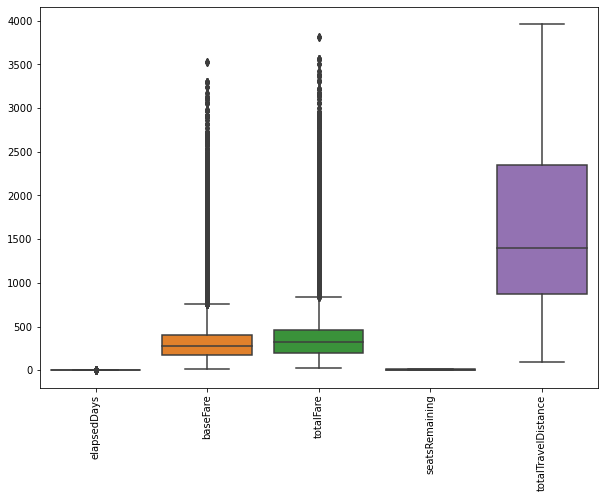

In [36]:
# outlire in dataset
plt.figure(figsize=(10,7))
sns.boxplot(data=df)
plt.xticks(rotation=90)

## <font color= '51b4e3'> Remove the outlier from total fare column 

{'whiskers': [<matplotlib.lines.Line2D at 0x25b9d437070>,
 'caps': [<matplotlib.lines.Line2D at 0x25b9d437610>,
 'boxes': [<matplotlib.lines.Line2D at 0x25b9d468d60>],
 'medians': [<matplotlib.lines.Line2D at 0x25b9d437bb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x25b9d437e80>],
 'means': []}

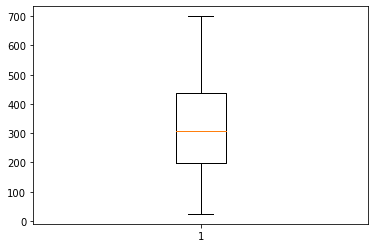

In [37]:
df = df[df.totalFare <= 700]
plt.boxplot(df.totalFare)

## <font color= '51b4e3'> Remove the outlier from base fare column

{'whiskers': [<matplotlib.lines.Line2D at 0x25b965af580>,
 'caps': [<matplotlib.lines.Line2D at 0x25b965afb20>,
 'boxes': [<matplotlib.lines.Line2D at 0x25b965af2b0>],
 'medians': [<matplotlib.lines.Line2D at 0x25b96598100>],
 'fliers': [<matplotlib.lines.Line2D at 0x25b965983d0>],
 'means': []}

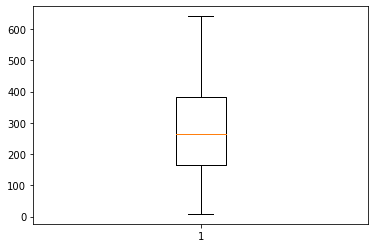

In [38]:
df = df[df.baseFare <= 700]
plt.boxplot(df.baseFare)

## <font color= '51b4e3'> Dataset without outliers 

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'elapsedDays'),
  Text(1, 0, 'baseFare'),
  Text(2, 0, 'totalFare'),
  Text(3, 0, 'seatsRemaining'),
  Text(4, 0, 'totalTravelDistance')])

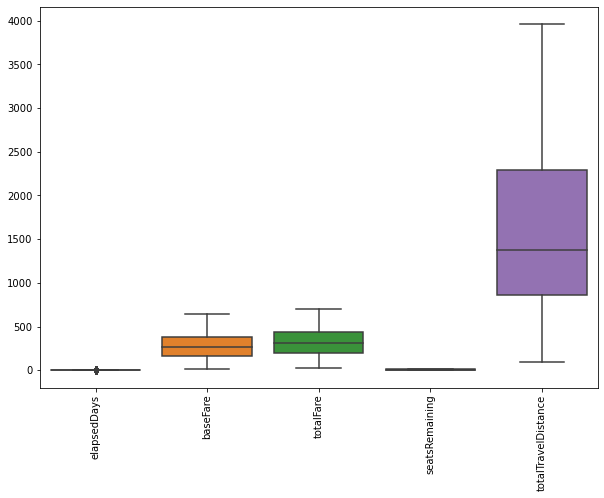

In [39]:
# outlire in dataset
plt.figure(figsize=(10,7))
sns.boxplot(data=df)
plt.xticks(rotation=90)

## <font color= '51b4e3'> Removing the noisy data by splitting the data in some columns that contain more than two values

In [40]:
# new data frame with split value columns
new = df["segmentsDepartureTimeEpochSeconds"].str.split("|", expand = True)
df["segmentsDepartureTimeEpochSeconds"]= new[0]

new = df["segmentsDepartureTimeRaw"].str.split("|", expand = True)
df["segmentsDepartureTimeRaw"]= new[0]

new = df["segmentsArrivalTimeEpochSeconds"].str.split("|", expand = True)
df["segmentsArrivalTimeEpochSeconds"]= new[0]

new = df["segmentsArrivalTimeRaw"].str.split("|", expand = True)
df["segmentsArrivalTimeRaw"]= new[0]

new = df["segmentsArrivalAirportCode"].str.split("|", expand = True)
df["segmentsArrivalAirportCode"]= new[0]

new = df["segmentsDepartureAirportCode"].str.split("|", expand = True)
df["segmentsDepartureAirportCode"]= new[0]

new = df["segmentsAirlineName"].str.split("|", expand = True)
df["segmentsAirlineName"]= new[0]

new = df["segmentsDurationInSeconds"].str.split("|", expand = True)
df["segmentsDurationInSeconds"]= new[0]

new = df["segmentsDistance"].str.split("|", expand = True)
df["segmentsDistance"]= new[0]

new = df["segmentsCabinCode"].str.split("|", expand = True)
df["segmentsCabinCode"]= new[0]

In [41]:
df.tail(10)

,flightDate,startingAirport,destinationAirport,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,...,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
921936,5/30/2022,ORD,SFO,0,false,false,true,431.62,478.59,7,...,1653948900,2022-05-30T17:15:00.000-05:00,1653965640,2022-05-30T19:54:00.000-07:00,SFO,ORD,American Airlines,16740,1847,coach
921937,5/30/2022,ORD,SFO,0,false,false,true,431.62,478.59,7,...,1653917400,2022-05-30T08:30:00.000-05:00,1653934200,2022-05-30T11:10:00.000-07:00,SFO,ORD,American Airlines,16800,1847,coach
921938,5/30/2022,ORD,SFO,0,false,false,true,459.53,508.60,7,...,1653947400,2022-05-30T16:50:00.000-05:00,1653964200,2022-05-30T19:30:00.000-07:00,SFO,ORD,Alaska Airlines,16800,1847,coach
921939,5/30/2022,ORD,SFO,0,false,false,true,478.14,528.60,9,...,1653918900,2022-05-30T08:55:00.000-05:00,1653935760,2022-05-30T11:36:00.000-07:00,SFO,ORD,United,16860,1847,coach
921940,5/30/2022,ORD,SFO,0,false,false,true,496.74,548.60,2,...,1653935580,2022-05-30T13:33:00.000-05:00,1653952380,2022-05-30T16:13:00.000-07:00,SFO,ORD,American Airlines,16800,1847,coach
921941,5/30/2022,ORD,SFO,0,false,false,false,533.95,597.60,7,...,1653906360,2022-05-30T05:26:00.000-05:00,1653915900,2022-05-30T07:05:00.000-06:00,DEN,ORD,United,9540,903,coach
921942,5/30/2022,ORD,SFO,0,false,false,true,559.07,615.60,9,...,1653957300,2022-05-30T19:35:00.000-05:00,1653973200,2022-05-30T22:00:00.000-07:00,SFO,ORD,United,15900,1847,coach
921943,5/30/2022,ORD,SFO,0,false,false,true,559.07,615.60,9,...,1653945120,2022-05-30T16:12:00.000-05:00,1653961800,2022-05-30T18:50:00.000-07:00,SFO,ORD,United,16680,1847,coach
921944,5/30/2022,ORD,SFO,0,false,false,true,559.07,615.60,9,...,1653963360,2022-05-30T21:16:00.000-05:00,1653980340,2022-05-30T23:59:00.000-07:00,SFO,ORD,United,16980,1847,coach
921945,5/30/2022,ORD,SFO,0,false,false,true,559.07,615.60,9,...,1653924900,2022-05-30T10:35:00.000-05:00,1653942240,2022-05-30T13:24:00.000-07:00,SFO,ORD,United,17340,1847,coach


## <font color= '51b4e3'> Some columns contain both date and time, however, we need only the time, so we did split the data according to the time 

In [42]:
new = df["segmentsDepartureTimeRaw"].str.split("T", expand = True)
df["segmentsDepartureTimeRaw"]= new[1]
new = df["segmentsArrivalTimeRaw"].str.split("T", expand = True)
df["segmentsArrivalTimeRaw"]= new[1]

## <font color= '51b4e3'> Convert the columns contain the seconds into hours 

In [43]:
df['segmentsArrivalTimeEpochInhours'] = pd.to_datetime(df["segmentsArrivalTimeEpochSeconds"], unit='s').dt.strftime("%H")
df['segmentsDepartureTimeEpochInhours '] = pd.to_datetime(df["segmentsDepartureTimeEpochSeconds"], unit='s').dt.strftime("%H")
df['segmentsDurationInhours '] = pd.to_datetime(df["segmentsDurationInSeconds"], unit='s').dt.strftime("%H")

In [44]:
df.tail(10)

,flightDate,startingAirport,destinationAirport,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,...,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode,segmentsArrivalTimeEpochInhours,segmentsDepartureTimeEpochInhours,segmentsDurationInhours
921936,5/30/2022,ORD,SFO,0,false,false,true,431.62,478.59,7,...,19:54:00.000-07:00,SFO,ORD,American Airlines,16740,1847,coach,02,22,04
921937,5/30/2022,ORD,SFO,0,false,false,true,431.62,478.59,7,...,11:10:00.000-07:00,SFO,ORD,American Airlines,16800,1847,coach,18,13,04
921938,5/30/2022,ORD,SFO,0,false,false,true,459.53,508.60,7,...,19:30:00.000-07:00,SFO,ORD,Alaska Airlines,16800,1847,coach,02,21,04
921939,5/30/2022,ORD,SFO,0,false,false,true,478.14,528.60,9,...,11:36:00.000-07:00,SFO,ORD,United,16860,1847,coach,18,13,04
921940,5/30/2022,ORD,SFO,0,false,false,true,496.74,548.60,2,...,16:13:00.000-07:00,SFO,ORD,American Airlines,16800,1847,coach,23,18,04
921941,5/30/2022,ORD,SFO,0,false,false,false,533.95,597.60,7,...,07:05:00.000-06:00,DEN,ORD,United,9540,903,coach,13,10,02
921942,5/30/2022,ORD,SFO,0,false,false,true,559.07,615.60,9,...,22:00:00.000-07:00,SFO,ORD,United,15900,1847,coach,05,00,04
921943,5/30/2022,ORD,SFO,0,false,false,true,559.07,615.60,9,...,18:50:00.000-07:00,SFO,ORD,United,16680,1847,coach,01,21,04
921944,5/30/2022,ORD,SFO,0,false,false,true,559.07,615.60,9,...,23:59:00.000-07:00,SFO,ORD,United,16980,1847,coach,06,02,04
921945,5/30/2022,ORD,SFO,0,false,false,true,559.07,615.60,9,...,13:24:00.000-07:00,SFO,ORD,United,17340,1847,coach,20,15,04


## <font color= '51b4e3'> The shape after preprocessing 

In [45]:
df.shape

(880990, 24)

## <font color= '51b4e3'> Save the cleaned data to be able to use 
 

In [46]:
df.to_csv('FlightDataset.csv', index=False, header=True)